In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier


In [2]:
ruta_datos = r"C:\Users\dnlls\OneDrive\Escritorio\PUMA\Neurociencias\Escritorio Neurociencias\6o Semestre\MODELOS\finalfer\datasetbtx"

dim_img = 128

clases_codificadas = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
nombres_clases = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
def cargar_dataset(directorio_base):
    imagenes = []
    etiquetas = []

    for categoria in clases_codificadas:
        ruta_categoria = os.path.join(directorio_base, categoria)
        for archivo in os.listdir(ruta_categoria):
            ruta_imagen = os.path.join(ruta_categoria, archivo)
            try:
                imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
                imagen = cv2.resize(imagen, (dim_img, dim_img))
                imagenes.append(imagen)
                etiquetas.append(clases_codificadas[categoria])
            except:
                continue

    return np.array(imagenes), np.array(etiquetas)


In [4]:
datos_entrenamiento, etiquetas_entrenamiento = cargar_dataset(os.path.join(ruta_datos, 'Training'))
datos_prueba, etiquetas_prueba = cargar_dataset(os.path.join(ruta_datos, 'Testing'))

datos_entrenamiento = datos_entrenamiento / 255.0
datos_prueba = datos_prueba / 255.0

datos_entrenamiento = np.expand_dims(datos_entrenamiento, axis=-1)
datos_prueba = np.expand_dims(datos_prueba, axis=-1)

etiquetas_entrenamiento_cat = to_categorical(etiquetas_entrenamiento, num_classes=4)
etiquetas_prueba_cat = to_categorical(etiquetas_prueba, num_classes=4)


C:\Users\dnlls\AppData\Local\Temp\ipykernel_11668\1057611720.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres_clases, y=conteo_clases, palette=paleta_colores)


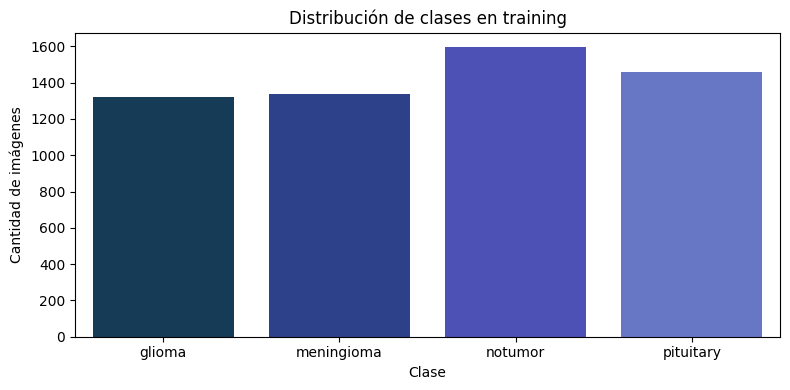

In [16]:
# DISTRIBUCIÓN DE CLASES
conteo_clases = [np.sum(etiquetas_entrenamiento == i) for i in range(4)]
paleta_colores = ['#0a3d62', '#1e3799', '#3c40c6', '#576cd6']

plt.figure(figsize=(8, 4))
sns.barplot(x=nombres_clases, y=conteo_clases, palette=paleta_colores)
plt.title("Distribución de clases en training")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.tight_layout()
plt.show()


In [6]:
# MODELO CNN
modelo_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(dim_img, dim_img, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

modelo_cnn.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

modelo_cnn.summary()


C:\Users\dnlls\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,260 (28.20 MB)

 Trainable params: 7,392,260 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# TRAIN CNN
modelo_cnn.fit(datos_entrenamiento, etiquetas_entrenamiento_cat,
               epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.5903 - loss: 0.8911 - val_accuracy: 0.1199 - val_loss: 2.6701
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - accuracy: 0.8249 - loss: 0.4383 - val_accuracy: 0.4182 - val_loss: 1.7661
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.8874 - loss: 0.3035 - val_accuracy: 0.4226 - val_loss: 2.1033
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.9149 - loss: 0.2097 - val_accuracy: 0.4602 - val_loss: 2.4859
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.9321 - loss: 0.1780 - val_accuracy: 0.4339 - val_loss: 2.9786
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.9493 - loss: 0.1402 - val_accuracy: 0.3876 - val_loss: 3.5506
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.9678 - loss: 0.0951 - val_accuracy: 0.5547 - val_loss: 2.5534
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.9762 - loss: 0

In [13]:
# EVALUACIÓN CNN
predicciones_cnn = np.argmax(modelo_cnn.predict(datos_prueba), axis=1)

print("Informe de Clasificación: CNN")
print(classification_report(etiquetas_prueba, predicciones_cnn, target_names=nombres_clases))


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Informe de Clasificación: CNN
              precision    recall  f1-score   support

      glioma       0.86      0.91      0.88       300
  meningioma       0.64      0.95      0.77       306
     notumor       0.97      1.00      0.98       405
   pituitary       1.00      0.42      0.59       300

    accuracy                           0.83      1311
   macro avg       0.87      0.82      0.81      1311
weighted avg       0.87      0.83      0.82      1311



In [9]:
# RANDOM FOREST
datos_entrenamiento_rf = datos_entrenamiento.reshape(len(datos_entrenamiento), -1)
datos_prueba_rf = datos_prueba.reshape(len(datos_prueba), -1)

modelo_rf = RandomForestClassifier(n_estimators=100)
modelo_rf.fit(datos_entrenamiento_rf, etiquetas_entrenamiento)
predicciones_rf = modelo_rf.predict(datos_prueba_rf)

print("Informe de Clasificación: Random Forest")
print(classification_report(etiquetas_prueba, predicciones_rf, target_names=nombres_clases))


Informe de Clasificación: Random Forest
              precision    recall  f1-score   support

      glioma       0.96      0.83      0.89       300
  meningioma       0.84      0.92      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.95      0.97      0.96       300

    accuracy                           0.94      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.94      0.93      1311



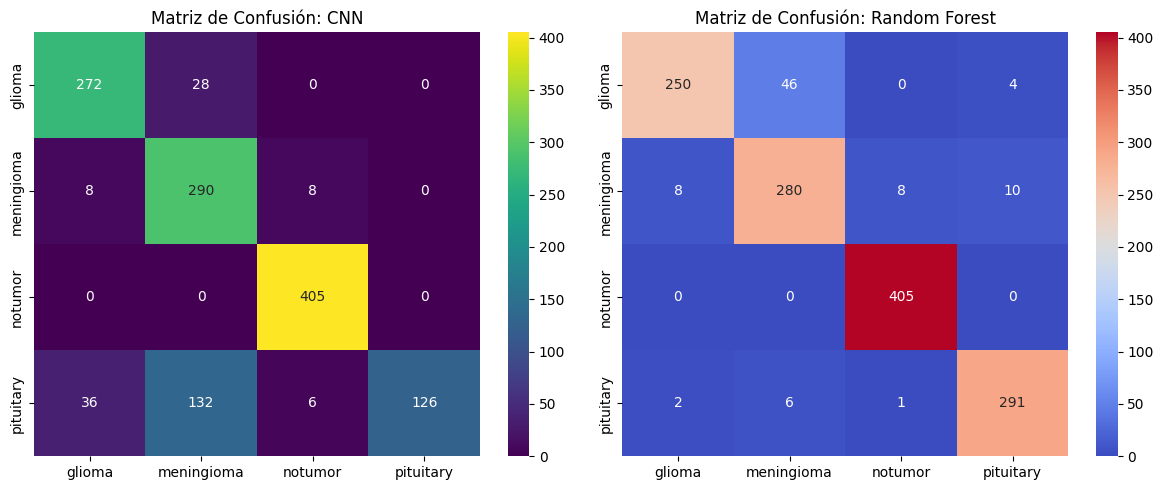

In [15]:
# MATRICES DE CONFUSIÓN
plt.figure(figsize=(12, 5))

# CNN
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(etiquetas_prueba, predicciones_cnn), annot=True, fmt='d', cmap='viridis')
plt.title('Matriz de Confusión: CNN')
plt.xticks(ticks=np.arange(4) + 0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(4) + 0.5, labels=nombres_clases)

# Random Forest
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(etiquetas_prueba, predicciones_rf), annot=True, fmt='d', cmap='coolwarm')
plt.title('Matriz de Confusión: Random Forest')
plt.xticks(ticks=np.arange(4) + 0.5, labels=nombres_clases)
plt.yticks(ticks=np.arange(4) + 0.5, labels=nombres_clases)

plt.tight_layout()
plt.show()


**ANÁLISIS DEL DATASET**
Para el presente proyecto se utilizó el dataset de tumores cerebrales (Brain Tumor Dataset) propuesto por el profesor. Este conjunto de datos contiene un total de 7,023 imágenes en formato .jpg, organizadas jerárquicamente en carpetas dentro de dos subdirectorios principales: “Training” y “Testing”. Cada uno de estos subdirectorios incluye a su vez subcarpetas correspondientes a las cuatro clases del conjunto de datos: glioma, meningioma, notumor y pituitary. Cada carpeta representa una categoría específica asociada al tipo de tumor (o ausencia del mismo) visible en las imágenes de resonancia magnética.

Inicialmente, se llevó a cabo un análisis exploratorio de la distribución de clases en el conjunto de entrenamiento. Este análisis se visualizó mediante un gráfico de barras, el cual permitió identificar que las clases se encuentran prácticamente equilibradas, lo que resulta favorable para el entrenamiento de modelos de clasificación, ya que reduce el riesgo de sesgo hacia alguna clase específica.

**TIPO DE PROBLEMA**
Al examinar la estructura del dataset, se observa que cada imagen está asociada a una etiqueta que indica su clase correspondiente (glioma, meningioma, notumor o pituitary). Esto permite identificar claramente que se trata de un problema de clasificación supervisada multiclase. En este tipo de problemas, el objetivo principal es que el modelo aprenda patrones distintivos que le permitan predecir correctamente la clase a la que pertenece una imagen no vista previamente.

Es importante destacar que, a diferencia de los problemas de regresión —donde la variable objetivo es continua o numérica— en este caso la variable objetivo es categórica, es decir, representa una cualidad y no una cantidad. La característica de ser un problema supervisado implica que durante el entrenamiento se dispone de ejemplos etiquetados, lo que permite al modelo recibir retroalimentación directa sobre el acierto o error de sus predicciones.

Además, esta naturaleza supervisada resalta la importancia de dividir los datos en conjuntos de entrenamiento y prueba. Esta división es fundamental para evaluar adecuadamente la capacidad de generalización del modelo y evitar fenómenos como el underfitting (subajuste) o overfitting (sobreajuste), que comprometerían la validez del modelo al enfrentarse a nuevos datos.

**PROPUESTAS DE MODELOS SUPERVISADOS**
Una vez determinado que el problema correspondía a una tarea de clasificación supervisada, se procedió a seleccionar e implementar modelos adecuados para abordar dicha tarea. En este proyecto se compararon dos enfoques distintos: uno basado en aprendizaje profundo, utilizando una red neuronal convolucional (CNN), y otro perteneciente al aprendizaje automático tradicional, empleando un clasificador Random Forest.

Las redes neuronales convolucionales están especialmente diseñadas para el procesamiento de imágenes, ya que poseen la capacidad de extraer características espaciales relevantes mediante el uso de múltiples filtros y capas especializadas. La arquitectura implementada incluye capas convolucionales, funciones de activación ReLU, capas de pooling para reducir la dimensionalidad, y capas densas al final para realizar la clasificación.

Por otro lado, el modelo Random Forest —aunque originalmente no fue concebido para trabajar con imágenes— se utilizó como modelo de referencia. Para ello, fue necesario transformar las imágenes en vectores unidimensionales (aplanados), lo que permitió aplicar este algoritmo clásico al problema. Esta comparación sirvió para evaluar el rendimiento diferencial entre un modelo especializado en imágenes (CNN) y un modelo más generalista como Random Forest.

Ambos modelos fueron entrenados utilizando el conjunto de datos destinado al entrenamiento, y posteriormente evaluados con el conjunto de prueba, lo que permitió medir su capacidad de generalización y su eficacia frente a datos no vistos. Esta estrategia también evidenció cómo distintos enfoques metodológicos pueden aplicarse a un mismo problema de clasificación, proporcionando perspectivas complementarias.

**EVALUACIÓN DE RESULTADOS**
Las metricas de evaluacion fueron: accuracy, precision, recall y f1-score.

**ANÁLISIS DE RESULTADOS**
El análisis comparativo de los informes de clasificación de los modelos Random Forest y Red Neuronal Convolucional (CNN) evidencia diferencias importantes en su desempeño, tanto a nivel global como por clase. En términos de exactitud general, el modelo Random Forest obtuvo un 94% de precisión, superando notablemente al modelo CNN, que alcanzó un 83%. Esto indica que Random Forest cometió menos errores al clasificar las imágenes del conjunto de prueba.

Al examinar el desempeño por clase, se observa que ambos modelos obtuvieron resultados similares en la categoría *glioma*, aunque Random Forest presentó mejor precisión y la CNN, mayor recall. Para *meningioma*, la CNN mostró un alto recall (0.95), indicando que detectó la mayoría de los casos, pero con baja precisión (0.64), lo que implica un alto número de falsos positivos. En contraste, Random Forest ofreció un equilibrio más adecuado entre ambas métricas. En la clase *no tumor*, ambos modelos alcanzaron un desempeño excelente, aunque Random Forest fue ligeramente superior. La diferencia más significativa se presentó en la clase *pituitary*, donde la CNN obtuvo una precisión perfecta (1.00) pero con un recall muy bajo (0.42), mientras que Random Forest mantuvo altos valores en ambas métricas.

Las métricas promedio también respaldan el mejor desempeño general de Random Forest: su F1-score macro y ponderado fue de 0.93, en comparación con 0.81 y 0.82, respectivamente, del modelo CNN. Esto indica que Random Forest no solo fue más preciso globalmente, sino también más consistente entre las diferentes clases, un aspecto relevante en problemas de clasificación multiclase.

En conclusión, aunque las CNN están específicamente diseñadas para el procesamiento de imágenes y suelen superar a los modelos tradicionales en muchas tareas visuales, en este caso particular Random Forest obtuvo mejores resultados. Esto puede atribuirse a una arquitectura subóptima de la CNN, un entrenamiento insuficiente o deficiencias en el preprocesamiento de los datos. El resultado resalta la importancia de comparar múltiples enfoques y no asumir que los modelos más complejos siempre generarán el mejor rendimiento. Además, sugiere que la CNN podría mejorar significativamente con ajustes adicionales.

**INTERPRETACIÓN**
Los resultados obtenidos evidencian un mejor desempeño global del modelo Random Forest, el cual alcanzó una precisión del 94%, superando significativamente a la CNN, que obtuvo un 83%. Esta diferencia se refleja también en las métricas de F1-score, tanto macro (0.93 vs. 0.81) como ponderado (0.93 vs. 0.82), indicando una mayor consistencia del modelo Random Forest en todas las clases.

A nivel individual, se observó que la CNN presentó un alto recall en algunas clases (por ejemplo, meningioma), pero con una precisión baja, lo que sugiere una tendencia a generar falsos positivos. En contraste, el Random Forest logró un equilibrio más adecuado entre precisión y recall en la mayoría de las clases, especialmente en la categoría pituitary, donde la CNN mostró un recall considerablemente bajo.

Estos hallazgos sugieren que, a pesar de que las CNN están especialmente diseñadas para tareas de visión por computadora, su efectividad puede verse limitada por una arquitectura insuficiente o por un entrenamiento subóptimo. En este caso particular, el enfoque basado en Random Forest demostró una mejor capacidad de generalización y mayor robustez en la clasificación de imágenes médicas.